In [37]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

In [38]:
if not os.path.exists("/kaggle/working/images/"):
    os.mkdir('/kaggle/working/images/')

In [50]:
def show(tensor, ch=1, size=(28,28), num=16, epoch=0, save=False):
    data = tensor.detach().cpu().view(-1,ch, *size) # B, 1, 28, 28
    grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 28, 28, 1
    plt.imshow(grid)
    plt.title(f"Epoch: {epoch}")
    plt.axis('off')
    if save:
        plt.savefig(f"/kaggle/working/images/fake_{epoch}.png")
    plt.show()

In [ ]:
epochs = 200
cur_step = 0
info_step=300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
l_rate = 1e-4
loss_func = nn.BCEWithLogitsLoss()

batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=batch_size)

In [41]:
def getBlock(nIn, nOut):
    return nn.Sequential(
        nn.Linear(nIn, nOut),
        nn.BatchNorm1d(nOut),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim = 64, img_dim = 784, h_dim = 128):
        super().__init__()
        self.generator = nn.Sequential(
            getBlock(z_dim, h_dim), # 64 -> 128
            getBlock(h_dim, h_dim*2), # 128 -> 256
            getBlock(h_dim*2, h_dim*4), # 256 -> 512 
            getBlock(h_dim*4, h_dim*8), # 512 -> 1024 
            nn.Linear(h_dim*8, img_dim), # 1024 -> 784 
            nn.Sigmoid() # to make images between 0 and 1
        )
    
    def forward(self, noise):
        return self.generator(noise)

def get_noise(batch, z_dim = 64):
    return torch.randn(batch, z_dim).to(device)

def get_disc_block(nIn, nOut):
    return nn.Sequential(
        nn.Linear(nIn, nOut),
        # nn.BatchNorm1d(nOut),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self, img_dim = 784, h_dim = 256):
        super().__init__()
        self.discriminator = nn.Sequential(
            get_disc_block(img_dim, h_dim*4), # 784 -> 1024
            get_disc_block(h_dim*4, h_dim*2), # 1024 -> 512
            get_disc_block(h_dim*2, h_dim), # 512 -> 256
            nn.Linear(h_dim, 1)
        )
    
    def forward(self, image):
        return self.discriminator(image)

In [42]:
generator = Generator(z_dim=z_dim).to(device)
gen_opt = torch.optim.Adam(generator.parameters(), lr = l_rate)

discriminator = Discriminator().to(device)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr = l_rate)

In [43]:
generator

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [44]:
discriminator

Discriminator(
  (discriminator): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [45]:
x,y = next(iter(dataloader))
x.shape

torch.Size([128, 1, 28, 28])

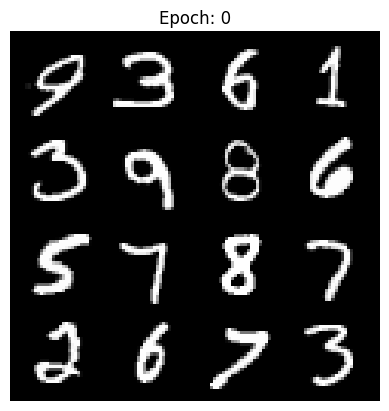

In [46]:
show(x)

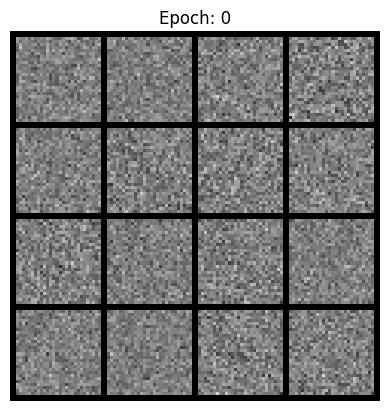

In [47]:
noise = get_noise(batch=16, z_dim=z_dim)
fake = generator(noise)
show(fake)

In [48]:
def generator_loss(loss_fn, gen_model, disc_model, batch_size, z_dim):
    noise = get_noise(batch=batch_size, z_dim=z_dim)
    fake_imgs = gen_model(noise)

    pred = disc_model(fake_imgs)
    labels = torch.ones_like(pred)

    loss = loss_fn(pred, labels)

    return loss

def disc_loss(loss_fn, gen_model, disc_model, batch_size, z_dim, real_imgs):
    noise = get_noise(batch=batch_size, z_dim=z_dim)
    fake_imgs = gen_model(noise)

    fake_pred = disc_model(fake_imgs.detach()) # keeping the generator out of autograd graph
    real_pred = disc_model(real_imgs)

    fake_target = torch.zeros_like(fake_pred)
    real_target = torch.ones_like(real_pred)

    fake_loss = loss_fn(fake_pred, fake_target)
    real_loss = loss_fn(real_pred, real_target)

    return (fake_loss + real_loss)/2

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0, Generator Loss: 28.14233501131336, Discrinimator Loss: 0.17384832925866553


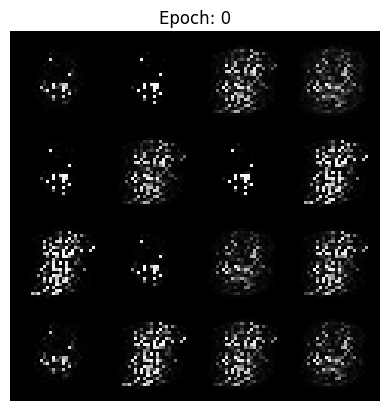

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1, Generator Loss: 24.899989993621904, Discrinimator Loss: 0.05586232374268244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2, Generator Loss: 36.485658364991345, Discrinimator Loss: 0.08301239468351203


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3, Generator Loss: 29.81305507943034, Discrinimator Loss: 0.0690892624946476


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4, Generator Loss: 29.341939692695934, Discrinimator Loss: 0.07894682430090445


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5, Generator Loss: 27.091324559102457, Discrinimator Loss: 0.09885514770940063


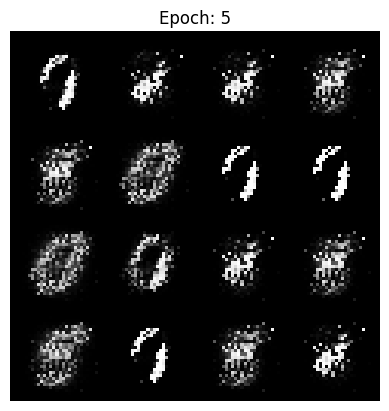

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6, Generator Loss: 24.698289680605132, Discrinimator Loss: 0.13341465172440317


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7, Generator Loss: 26.32596869642536, Discrinimator Loss: 0.09962263751458522


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8, Generator Loss: 26.55681266138951, Discrinimator Loss: 0.08600996266886796


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9, Generator Loss: 25.93498698870341, Discrinimator Loss: 0.0956179211361814


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10, Generator Loss: 27.369098536670208, Discrinimator Loss: 0.09456587291818626


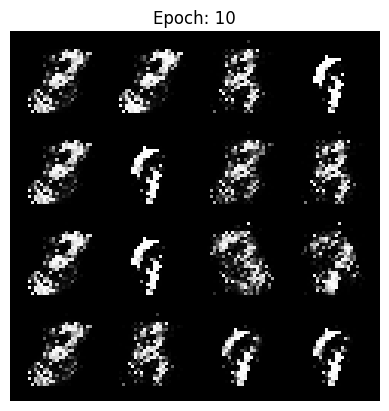

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11, Generator Loss: 25.78394786392649, Discrinimator Loss: 0.09566911676544503


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12, Generator Loss: 24.16631582255165, Discrinimator Loss: 0.1109239533091871


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13, Generator Loss: 25.055010887483757, Discrinimator Loss: 0.08843161245340525


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14, Generator Loss: 23.96565254529317, Discrinimator Loss: 0.11200581156344924


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15, Generator Loss: 26.8047351402541, Discrinimator Loss: 0.07842286931645504


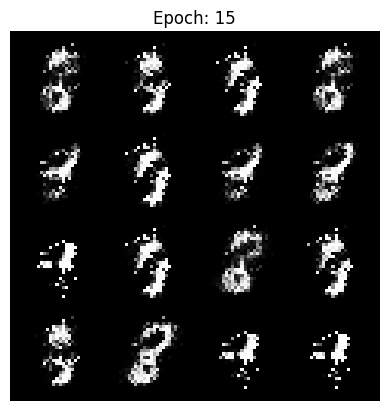

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16, Generator Loss: 24.78301081309716, Discrinimator Loss: 0.0950044426038706


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17, Generator Loss: 25.48131776228547, Discrinimator Loss: 0.08444318146227185


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18, Generator Loss: 25.077010514835518, Discrinimator Loss: 0.08216666137028976


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19, Generator Loss: 26.378548839439947, Discrinimator Loss: 0.0677161254886111


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20, Generator Loss: 24.941968221217394, Discrinimator Loss: 0.08283407495264328


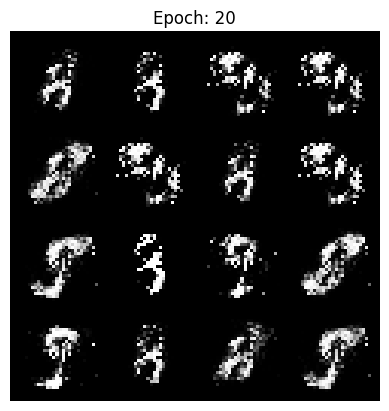

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21, Generator Loss: 25.074938155710697, Discrinimator Loss: 0.08544517342897961


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22, Generator Loss: 24.709954312692087, Discrinimator Loss: 0.08158155872767263


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23, Generator Loss: 24.30252004911502, Discrinimator Loss: 0.09714554110814788


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24, Generator Loss: 25.894611693918705, Discrinimator Loss: 0.08070078115224533


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25, Generator Loss: 24.106854119648535, Discrinimator Loss: 0.10915263057298337


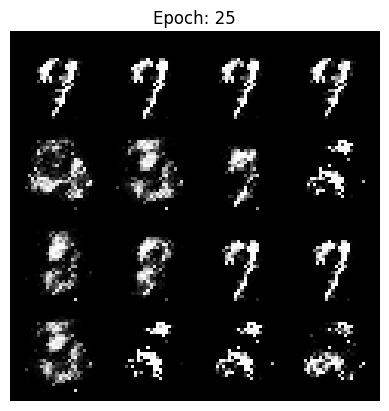

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 26, Generator Loss: 24.294012304395437, Discrinimator Loss: 0.09589790358950268


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 27, Generator Loss: 25.47900938987732, Discrinimator Loss: 0.10700186468739048


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 28, Generator Loss: 23.656104151159525, Discrinimator Loss: 0.11501101158986178


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 29, Generator Loss: 22.530774167428415, Discrinimator Loss: 0.120297715776663


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 30, Generator Loss: 26.480346720665693, Discrinimator Loss: 0.08698615023149614


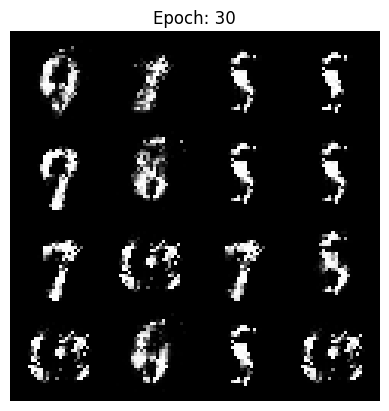

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 31, Generator Loss: 25.291795535633963, Discrinimator Loss: 0.0910715206146051


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 32, Generator Loss: 24.337650392204523, Discrinimator Loss: 0.10055124477245651


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 33, Generator Loss: 25.196480628103018, Discrinimator Loss: 0.10931061104596058


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 34, Generator Loss: 25.7885718892018, Discrinimator Loss: 0.08103318903901406


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 35, Generator Loss: 24.40501680970192, Discrinimator Loss: 0.09978151947871083


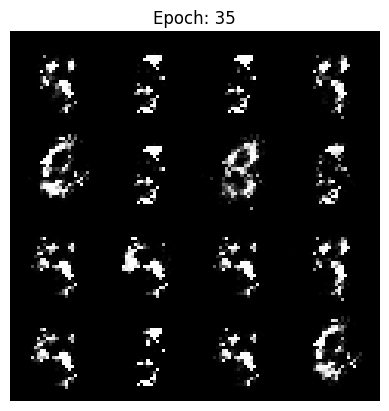

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 36, Generator Loss: 25.037181586027145, Discrinimator Loss: 0.10587255287858473


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 37, Generator Loss: 23.788384957859915, Discrinimator Loss: 0.12153891521120386


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 38, Generator Loss: 24.91798245658477, Discrinimator Loss: 0.11334793092828477


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 39, Generator Loss: 25.200849218914907, Discrinimator Loss: 0.11032880917900911


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 40, Generator Loss: 22.37045469880104, Discrinimator Loss: 0.1517296839701885


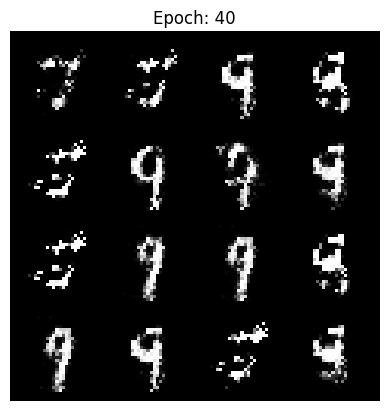

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 41, Generator Loss: 21.97664932658275, Discrinimator Loss: 0.17182724127875795


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 42, Generator Loss: 20.15054078648488, Discrinimator Loss: 0.19014837676998772


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 43, Generator Loss: 21.020426526665688, Discrinimator Loss: 0.17284254214488706


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 44, Generator Loss: 19.76761030840377, Discrinimator Loss: 0.20441312841042722


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 45, Generator Loss: 21.332632762690384, Discrinimator Loss: 0.1927215128186314


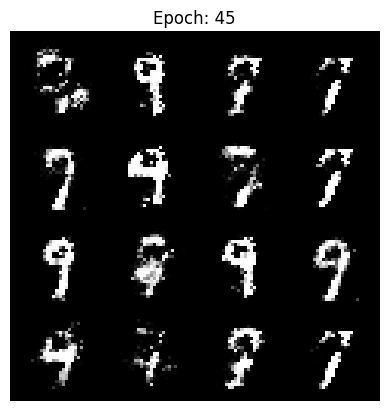

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 46, Generator Loss: 18.595941194022696, Discrinimator Loss: 0.23295631724370955


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 47, Generator Loss: 20.192924275373418, Discrinimator Loss: 0.2068287627431952


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 48, Generator Loss: 18.047251660376787, Discrinimator Loss: 0.2157089320656572


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 49, Generator Loss: 18.12532498749594, Discrinimator Loss: 0.23182303947154045


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 50, Generator Loss: 17.09476411404709, Discrinimator Loss: 0.2905835071724141


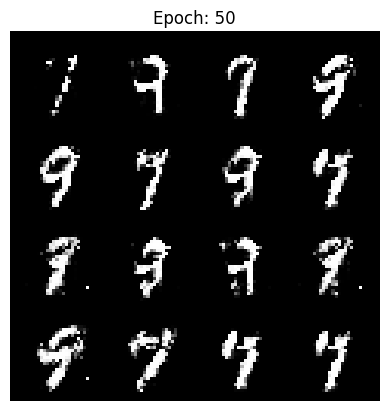

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 51, Generator Loss: 16.526046422620613, Discrinimator Loss: 0.28090059090269887


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 52, Generator Loss: 17.680361738428473, Discrinimator Loss: 0.2524087930311604


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 53, Generator Loss: 17.35554015636444, Discrinimator Loss: 0.24896520661180452


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 54, Generator Loss: 16.999099363262456, Discrinimator Loss: 0.2657998773793224


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 55, Generator Loss: 17.98602429466943, Discrinimator Loss: 0.25122425252872443


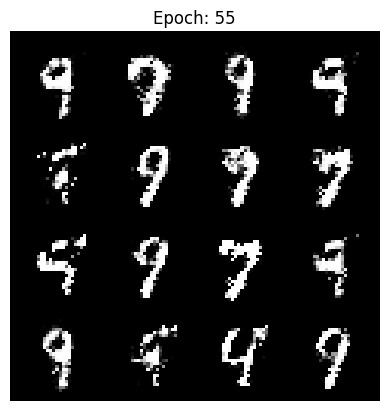

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 56, Generator Loss: 17.50920113734901, Discrinimator Loss: 0.2590054493169494


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 57, Generator Loss: 17.645977118362982, Discrinimator Loss: 0.2673942418308191


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 58, Generator Loss: 16.484780972202618, Discrinimator Loss: 0.2934531291296783


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 59, Generator Loss: 16.177007833495736, Discrinimator Loss: 0.3066472461262795


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 60, Generator Loss: 15.504869279141227, Discrinimator Loss: 0.33027278048878844


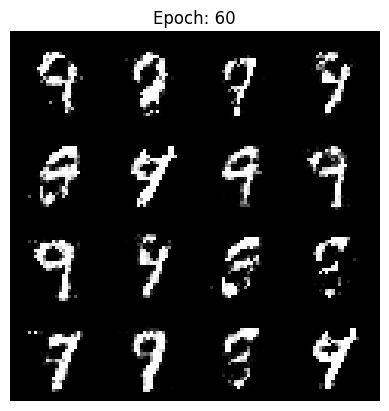

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 61, Generator Loss: 15.680166382963458, Discrinimator Loss: 0.332727438416138


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 62, Generator Loss: 15.851693019270897, Discrinimator Loss: 0.3308962866528115


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 63, Generator Loss: 15.478428856780132, Discrinimator Loss: 0.3450023510764974


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 64, Generator Loss: 15.532534537216028, Discrinimator Loss: 0.3560481667082058


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 65, Generator Loss: 15.567168289795518, Discrinimator Loss: 0.36392714115208946


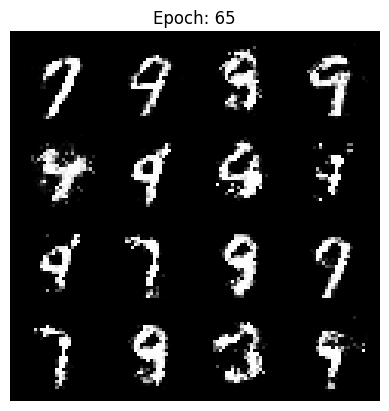

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 66, Generator Loss: 14.939934430023035, Discrinimator Loss: 0.3653056671852634


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 67, Generator Loss: 14.543184069295725, Discrinimator Loss: 0.383281822927529


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 68, Generator Loss: 14.753921068583926, Discrinimator Loss: 0.4006912304709355


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 69, Generator Loss: 14.56630922233065, Discrinimator Loss: 0.39657475681936677


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 70, Generator Loss: 14.55399126249055, Discrinimator Loss: 0.4032741430855822


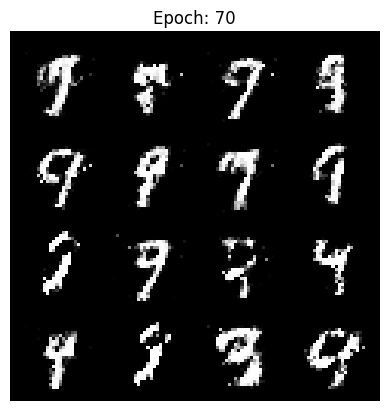

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 71, Generator Loss: 14.129935609797636, Discrinimator Loss: 0.43514478623789427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 72, Generator Loss: 13.521101364245018, Discrinimator Loss: 0.4686118803413895


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 73, Generator Loss: 13.582699858273068, Discrinimator Loss: 0.4857066162706663


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 74, Generator Loss: 13.159318273887038, Discrinimator Loss: 0.5111930834439894


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 75, Generator Loss: 13.02295407652855, Discrinimator Loss: 0.5214285483040536


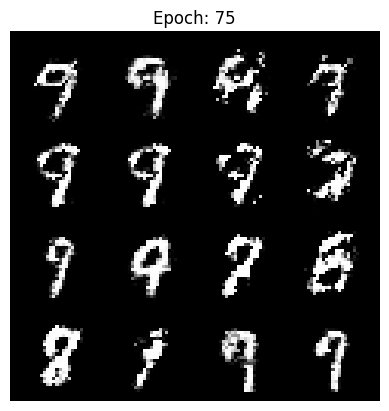

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 76, Generator Loss: 13.024494623144468, Discrinimator Loss: 0.5335739716150177


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 77, Generator Loss: 12.887747532998523, Discrinimator Loss: 0.5461029851576313


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 78, Generator Loss: 12.076322993263602, Discrinimator Loss: 0.6153722738963552


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 79, Generator Loss: 11.697869593277574, Discrinimator Loss: 0.6429282983881421


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 80, Generator Loss: 11.253848873699704, Discrinimator Loss: 0.711310226858283


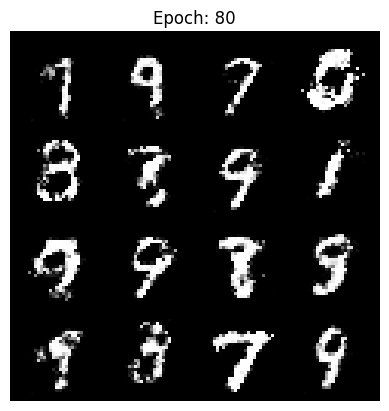

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 81, Generator Loss: 10.823609564453363, Discrinimator Loss: 0.7320013803158266


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 82, Generator Loss: 10.398870162665844, Discrinimator Loss: 0.771836437828218


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 83, Generator Loss: 10.00008438092967, Discrinimator Loss: 0.8331368237074154


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 84, Generator Loss: 9.725051259621978, Discrinimator Loss: 0.8586658609177297


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 85, Generator Loss: 9.706485020617643, Discrinimator Loss: 0.8752515052522843


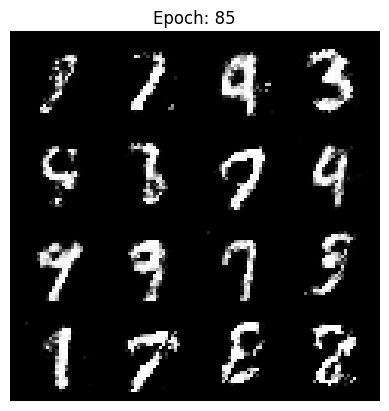

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 86, Generator Loss: 9.328903939264515, Discrinimator Loss: 0.9283950723474845


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 87, Generator Loss: 8.95250483819594, Discrinimator Loss: 0.9540065615437925


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 88, Generator Loss: 9.106269567273557, Discrinimator Loss: 0.960359177358138


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 89, Generator Loss: 8.872917640022933, Discrinimator Loss: 0.9820938211244842


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 90, Generator Loss: 8.79835268544654, Discrinimator Loss: 1.0164641618806247


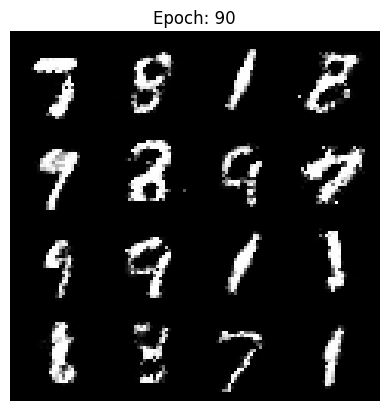

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 91, Generator Loss: 8.497452962212265, Discrinimator Loss: 1.0222724126263831


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 92, Generator Loss: 8.221784707779685, Discrinimator Loss: 1.0831996976630762


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 93, Generator Loss: 8.221236262780925, Discrinimator Loss: 1.072850806832624


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 94, Generator Loss: 8.23543703959634, Discrinimator Loss: 1.0855348315866042


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 95, Generator Loss: 8.010998808157941, Discrinimator Loss: 1.1046851759310812


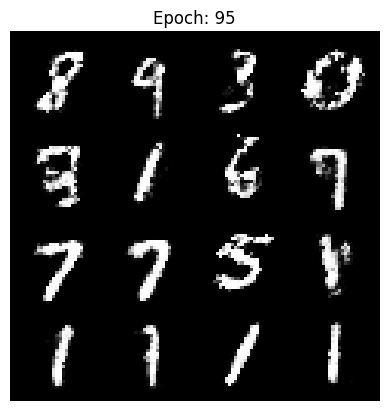

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 96, Generator Loss: 7.915415340103209, Discrinimator Loss: 1.1236934044864029


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 97, Generator Loss: 7.7307118540629745, Discrinimator Loss: 1.1435793152777478


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 98, Generator Loss: 7.7407359797507524, Discrinimator Loss: 1.1689992426739384


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 99, Generator Loss: 7.63491824703912, Discrinimator Loss: 1.1644402358991404


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 100, Generator Loss: 7.417562579425673, Discrinimator Loss: 1.189788395888172


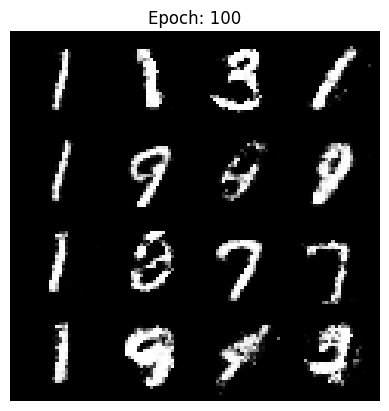

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 101, Generator Loss: 7.412664665219684, Discrinimator Loss: 1.2020140085369349


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 102, Generator Loss: 7.322792345037063, Discrinimator Loss: 1.2168444799802576


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 103, Generator Loss: 7.373461456038058, Discrinimator Loss: 1.2262441619920235


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 104, Generator Loss: 7.299668989454706, Discrinimator Loss: 1.2347951598155003


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 105, Generator Loss: 7.265190940660735, Discrinimator Loss: 1.222740045399405


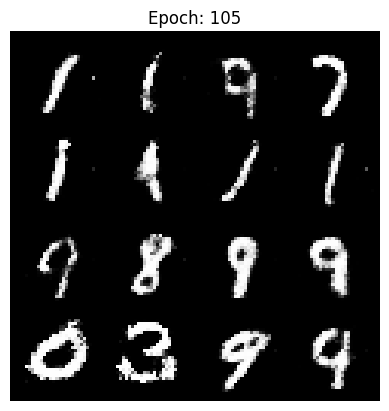

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 106, Generator Loss: 7.306665239234765, Discrinimator Loss: 1.230636354147767


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 107, Generator Loss: 7.27225751336664, Discrinimator Loss: 1.2205768731267501


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 108, Generator Loss: 7.094965226637821, Discrinimator Loss: 1.2596225465725486


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 109, Generator Loss: 7.059963818949957, Discrinimator Loss: 1.267391716518129


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 110, Generator Loss: 6.957594060959916, Discrinimator Loss: 1.2866433646219473


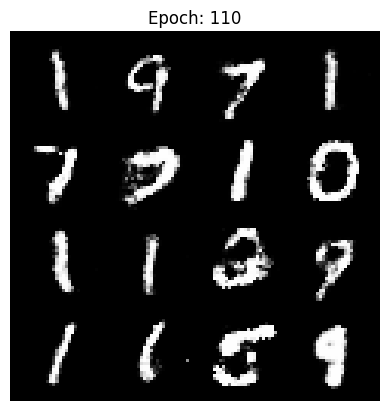

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 111, Generator Loss: 6.833647038166721, Discrinimator Loss: 1.289420292285892


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 112, Generator Loss: 6.768463367906709, Discrinimator Loss: 1.2984307366035257


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 113, Generator Loss: 6.890963011421263, Discrinimator Loss: 1.2768574063666165


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 114, Generator Loss: 6.797197180489699, Discrinimator Loss: 1.3010394567002852


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 115, Generator Loss: 6.825223818421364, Discrinimator Loss: 1.307453278452158


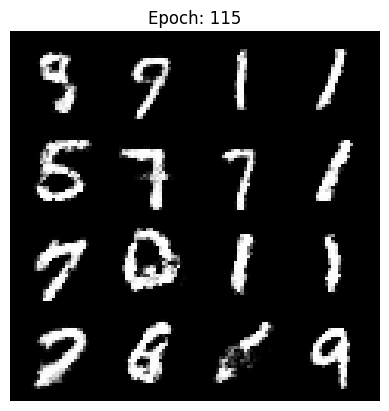

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 116, Generator Loss: 6.764979095198214, Discrinimator Loss: 1.29924669675529


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 117, Generator Loss: 6.85874871412913, Discrinimator Loss: 1.3076064807828516


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 118, Generator Loss: 6.749167329942186, Discrinimator Loss: 1.3126036492176354


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 119, Generator Loss: 6.856590531766415, Discrinimator Loss: 1.292315645609051


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 120, Generator Loss: 6.603584110736847, Discrinimator Loss: 1.3194455632086222


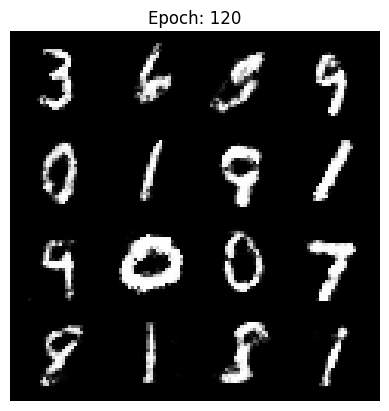

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 121, Generator Loss: 6.719167274422944, Discrinimator Loss: 1.311372205382213


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 122, Generator Loss: 6.68326607470711, Discrinimator Loss: 1.3156565445630501


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 123, Generator Loss: 6.631352633237839, Discrinimator Loss: 1.3224406375860174


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 124, Generator Loss: 6.573918019421399, Discrinimator Loss: 1.3141453310381621


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 125, Generator Loss: 6.645173267150919, Discrinimator Loss: 1.312613961674894


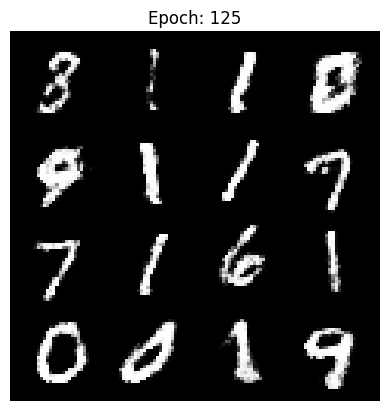

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 126, Generator Loss: 6.676908776474495, Discrinimator Loss: 1.3073410893169541


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 127, Generator Loss: 6.713175551655392, Discrinimator Loss: 1.3026961623691022


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 128, Generator Loss: 6.654614261041085, Discrinimator Loss: 1.3248906585698326


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 129, Generator Loss: 6.523242378296952, Discrinimator Loss: 1.3303271428837131


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 130, Generator Loss: 6.5231545604765415, Discrinimator Loss: 1.3434295256932576


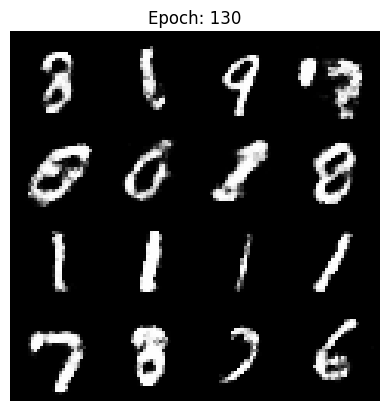

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 131, Generator Loss: 6.5943611621235805, Discrinimator Loss: 1.3160905377784122


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 132, Generator Loss: 6.515296280694504, Discrinimator Loss: 1.3259871468956892


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 133, Generator Loss: 6.551276794634759, Discrinimator Loss: 1.3314644288426887


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 134, Generator Loss: 6.606421558807294, Discrinimator Loss: 1.3153570948634297


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 135, Generator Loss: 7.194087424625953, Discrinimator Loss: 1.2962456910948579


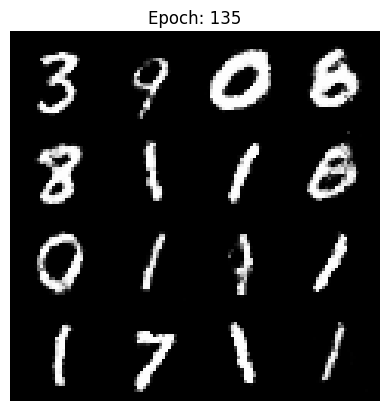

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 136, Generator Loss: 6.473974013390641, Discrinimator Loss: 1.3352944886622329


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 137, Generator Loss: 6.407787327344219, Discrinimator Loss: 1.3296622483370204


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 138, Generator Loss: 6.468424592788021, Discrinimator Loss: 1.3280728708487004


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 139, Generator Loss: 6.620545615752538, Discrinimator Loss: 1.318275802147885


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 140, Generator Loss: 6.513848181813955, Discrinimator Loss: 1.330044686095789


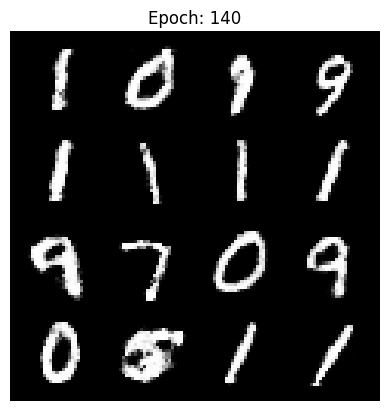

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 141, Generator Loss: 6.45979509751002, Discrinimator Loss: 1.327087441769739


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 142, Generator Loss: 6.488699674606323, Discrinimator Loss: 1.3354092059501756


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 143, Generator Loss: 6.439832749466102, Discrinimator Loss: 1.3396928651879232


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 144, Generator Loss: 6.478946906514466, Discrinimator Loss: 1.3372631618985906


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 145, Generator Loss: 6.378802529536188, Discrinimator Loss: 1.3461100605782121


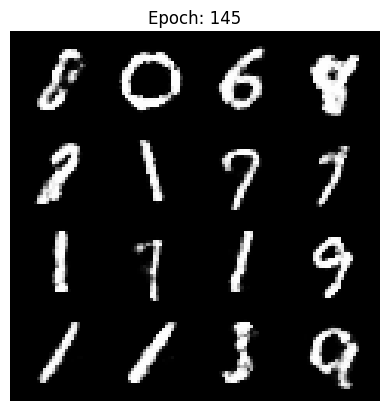

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 146, Generator Loss: 6.419239645823836, Discrinimator Loss: 1.3339057145640254


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 147, Generator Loss: 6.401386533553402, Discrinimator Loss: 1.357953695114702


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 148, Generator Loss: 6.4004692658782005, Discrinimator Loss: 1.3555659581907094


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 149, Generator Loss: 6.313648199041684, Discrinimator Loss: 1.3576115972052019


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 150, Generator Loss: 6.4564788701633615, Discrinimator Loss: 1.3522451158302526


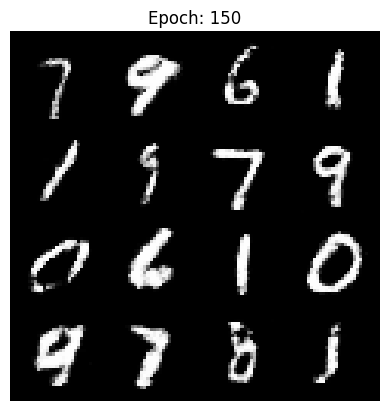

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 151, Generator Loss: 6.335243472829461, Discrinimator Loss: 1.3567415025706093


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 152, Generator Loss: 6.360745054359238, Discrinimator Loss: 1.3618154114422698


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 153, Generator Loss: 6.3900763889153795, Discrinimator Loss: 1.351634560463329


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 154, Generator Loss: 6.311115780534844, Discrinimator Loss: 1.3789931350232412


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 155, Generator Loss: 7.060600003538032, Discrinimator Loss: 1.2860543898617227


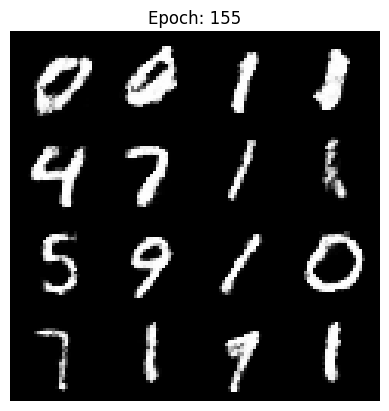

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 156, Generator Loss: 6.378924520996709, Discrinimator Loss: 1.3621806565206498


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 157, Generator Loss: 6.56043251696974, Discrinimator Loss: 1.324521648697555


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 158, Generator Loss: 6.359662939794362, Discrinimator Loss: 1.3776879087866594


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 159, Generator Loss: 6.332388926297426, Discrinimator Loss: 1.3593056586881478


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 160, Generator Loss: 6.28461663549145, Discrinimator Loss: 1.3700271752507736


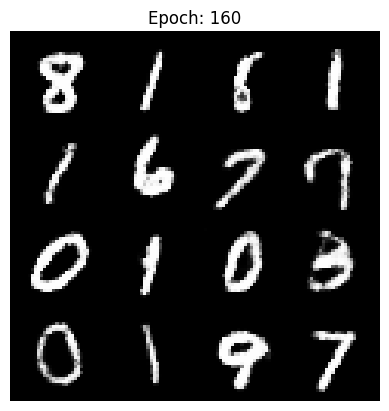

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 161, Generator Loss: 6.248804352556665, Discrinimator Loss: 1.4372960734181106


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 162, Generator Loss: 6.242116599343717, Discrinimator Loss: 1.3740011083427817


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 163, Generator Loss: 6.247489744176467, Discrinimator Loss: 1.3838406619615853


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 164, Generator Loss: 6.1917404200260835, Discrinimator Loss: 1.3901320652415354


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 165, Generator Loss: 6.283672099933028, Discrinimator Loss: 1.3777432905044407


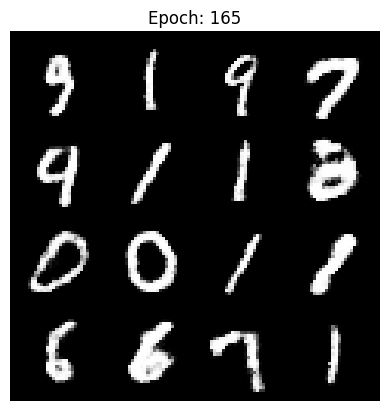

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 166, Generator Loss: 6.291409149765968, Discrinimator Loss: 1.3744227138037484


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 167, Generator Loss: 6.3006793127084775, Discrinimator Loss: 1.3653372693806887


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 168, Generator Loss: 6.280287806255122, Discrinimator Loss: 1.382773046536992


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 169, Generator Loss: 6.263270037869613, Discrinimator Loss: 1.3798401576156418


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 170, Generator Loss: 6.253606632662316, Discrinimator Loss: 1.3727387997787446


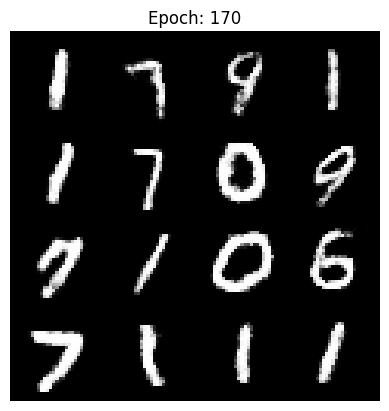

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 171, Generator Loss: 6.321165555777649, Discrinimator Loss: 1.3688912223248433


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 172, Generator Loss: 6.313310480987032, Discrinimator Loss: 1.3700013250733416


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 173, Generator Loss: 6.246304973339041, Discrinimator Loss: 1.3712279689498246


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 174, Generator Loss: 6.222326372439663, Discrinimator Loss: 1.3696398277922224


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 175, Generator Loss: 6.38395462029924, Discrinimator Loss: 1.366298784967512


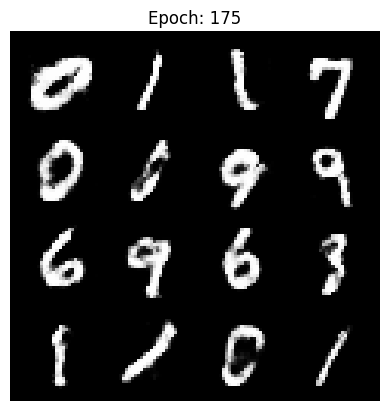

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 176, Generator Loss: 6.315126097761095, Discrinimator Loss: 1.3523318744264543


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 177, Generator Loss: 6.3203684234370785, Discrinimator Loss: 1.35522082564421


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 178, Generator Loss: 6.324246581333379, Discrinimator Loss: 1.3598181323613971


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 179, Generator Loss: 6.402393140209218, Discrinimator Loss: 1.364823446997131


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 180, Generator Loss: 6.3398985508829355, Discrinimator Loss: 1.36570640001446


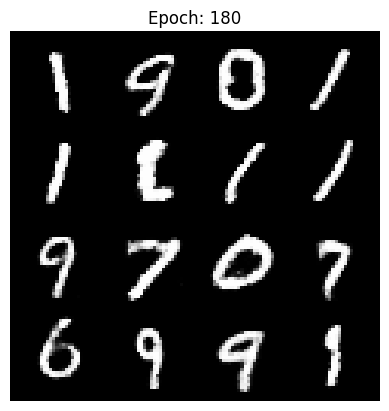

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 181, Generator Loss: 6.360906956406931, Discrinimator Loss: 1.3649820938395958


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 182, Generator Loss: 6.406120669096708, Discrinimator Loss: 1.3444160501627873


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 183, Generator Loss: 6.396869163649778, Discrinimator Loss: 1.3495151616322498


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 184, Generator Loss: 6.36310126259923, Discrinimator Loss: 1.343555621492366


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 185, Generator Loss: 6.398115589593847, Discrinimator Loss: 1.3541773136239499


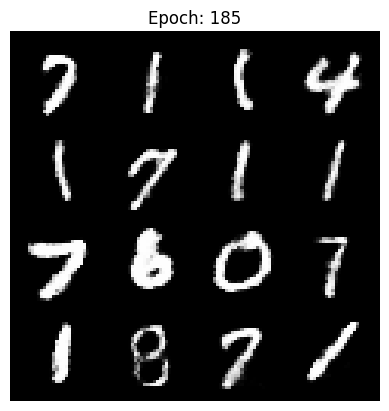

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 186, Generator Loss: 6.364691364889343, Discrinimator Loss: 1.3599591542345781


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 187, Generator Loss: 6.4296502796933055, Discrinimator Loss: 1.3502254229970276


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 188, Generator Loss: 6.440902032578985, Discrinimator Loss: 1.348153824529921


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 189, Generator Loss: 6.357753889635205, Discrinimator Loss: 1.3508550350864728


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 190, Generator Loss: 6.383732689234118, Discrinimator Loss: 1.3512519445891182


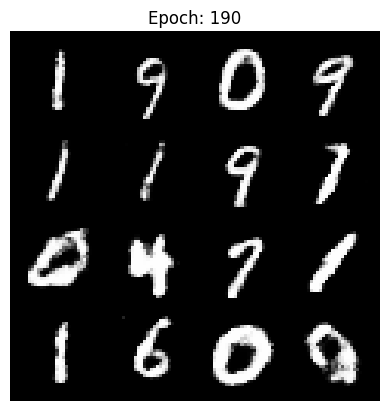

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 191, Generator Loss: 6.341195394595464, Discrinimator Loss: 1.3441406534208606


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 192, Generator Loss: 6.477824705652893, Discrinimator Loss: 1.3348121451369177


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 193, Generator Loss: 6.481243635217349, Discrinimator Loss: 1.3408227717348684


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 194, Generator Loss: 6.385470587139328, Discrinimator Loss: 1.331632030584539


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 195, Generator Loss: 6.43783120221148, Discrinimator Loss: 1.3349785710064073


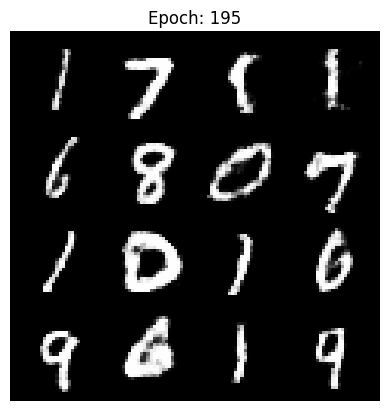

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 196, Generator Loss: 6.50633469534417, Discrinimator Loss: 1.32856887493593


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 197, Generator Loss: 6.556027951960762, Discrinimator Loss: 1.3136798974592239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 198, Generator Loss: 6.481004134130974, Discrinimator Loss: 1.3314922756981105


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 199, Generator Loss: 6.517121277749538, Discrinimator Loss: 1.320778182009235


In [51]:
for epoch in range(epochs):
    for real_imgs, _ in tqdm(dataloader):
        # Train the discriminator for k=1 as per the paper
        disc_opt.zero_grad()

        real_imgs = real_imgs.view(-1, 784).to(device) # flatten the data and set to default device
        batch = len(real_imgs)

        d_loss = disc_loss(loss_fn=loss_func, gen_model=generator, 
                  disc_model=discriminator, batch_size=batch, 
                  z_dim=z_dim, real_imgs=real_imgs)
        
        d_loss.backward(retain_graph=True)
        disc_opt.step()

        # Train the generator as per the paper
        gen_opt.zero_grad()

        g_loss = generator_loss(loss_fn=loss_func, gen_model=generator, 
                                disc_model=discriminator, batch_size=batch, 
                                z_dim=z_dim)
        
        g_loss.backward(retain_graph=True)
        gen_opt.step()


        # Statistics
        mean_disc_loss += d_loss.item()/batch
        mean_gen_loss += g_loss.item()/batch
    print(f"Epoch: {epoch}, Generator Loss: {mean_gen_loss}, Discrinimator Loss: {mean_disc_loss}")
    mean_disc_loss = 0
    mean_gen_loss = 0
    if epoch%5==0:
        fake_noise = get_noise(16, z_dim)
        fake_imgs = generator(fake_noise)
        show(fake_imgs, epoch=epoch, save=True)


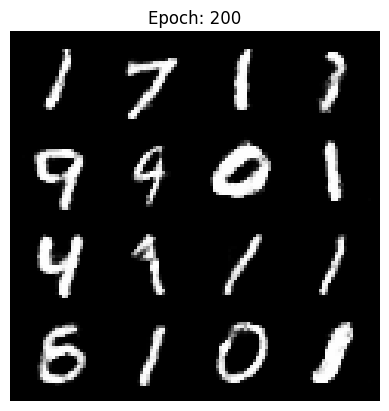

In [54]:
fake_noise = get_noise(16, z_dim)
fake_imgs = generator(fake_noise)
show(fake_imgs, epoch=epoch+1, save=True)

In [60]:
import glob
import PIL

In [59]:
imgs = glob.glob('/kaggle/working/images/*.png')
len(imgs)

41

In [64]:
imgs.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
images = []
for i in imgs:
    images.append(PIL.Image.open(i))

images.append(images[0])

In [66]:
images[0].save('GAN-Pytorch.gif', save_all=True, append_images=images, duration=100, loop=100)